In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
import missingno as msno
from collections import Counter
import re
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
file_path = '/content/Обращения.xlsx'


# Читаем файл
df = pd.read_excel('Обращения.xlsx', sheet_name='Result 1')


print("ДАННЫЕ УСПЕШНО ЗАГРУЖЕНЫ")

print(f"Размер данных: {df.shape[0]} строк, {df.shape[1]} колонок")
print("\nПервые 5 строк:")
display(df.head())

ДАННЫЕ УСПЕШНО ЗАГРУЖЕНЫ
Размер данных: 2553 строк, 4 колонок

Первые 5 строк:


,Дата обращения,Описание,Тема обращения,Идентификатор устройства
0,2025-10-10T07:52:33+03:00[Europe/Moscow],Здравствуйте! Квартира по адресу: Ул. Гризодуб...,Запрос портала,177045
1,2025-09-22T10:47:27+03:00[Europe/Moscow],"По адресу Стрелецкая улица, дом 9, корпус 2 пр...",Запрос портала,86874
2,2025-09-05T17:44:29+03:00[Europe/Moscow],Не могут открыть дверь через приложение . Со с...,Приложение. Умные решения,11699
3,2025-09-06T12:55:35+03:00[Europe/Moscow],Вадим хочет установить в квартире по адресу: <...,Приложение. Умные решения,51120
4,2025-10-17T08:09:09+03:00[Europe/Moscow],Не могу подключить управление домофона чтобы у...,Запрос портала,179157


In [3]:
print("ОСНОВНАЯ ИНФОРМАЦИЯ О ДАННЫХ")


print("\nИнформация о типах данных:")
print(df.info())

print("\nОписательная статистика:")
print(df.describe(include='all'))

print("\nИмена колонок:")
for i, col in enumerate(df.columns, 1):
    print(f"{i}. {col}")

# Переименуем колонки для удобства (если нужно)
df.columns = ['Дата_обращения', 'Описание', 'Тема_обращения', 'Идентификатор_устройства']

ОСНОВНАЯ ИНФОРМАЦИЯ О ДАННЫХ

Информация о типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2553 entries, 0 to 2552
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Дата обращения            2553 non-null   object
 1   Описание                  2552 non-null   object
 2   Тема обращения            2553 non-null   object
 3   Идентификатор устройства  2553 non-null   object
dtypes: object(4)
memory usage: 79.9+ KB
None

Описательная статистика:
                                  Дата обращения  \
count                                       2553   
unique                                      2550   
top     2025-09-23T08:35:36+03:00[Europe/Moscow]   
freq                                           2   

                                Описание  Тема обращения  \
count                               2552            2553   
unique                              2545              45   


АНАЛИЗ ПРОПУЩЕННЫХ ДАННЫХ
                    Колонка  Пропущено  Процент
0            Дата_обращения          0  0.00000
1                  Описание          1  0.03917
2            Тема_обращения          0  0.00000
3  Идентификатор_устройства          0  0.00000


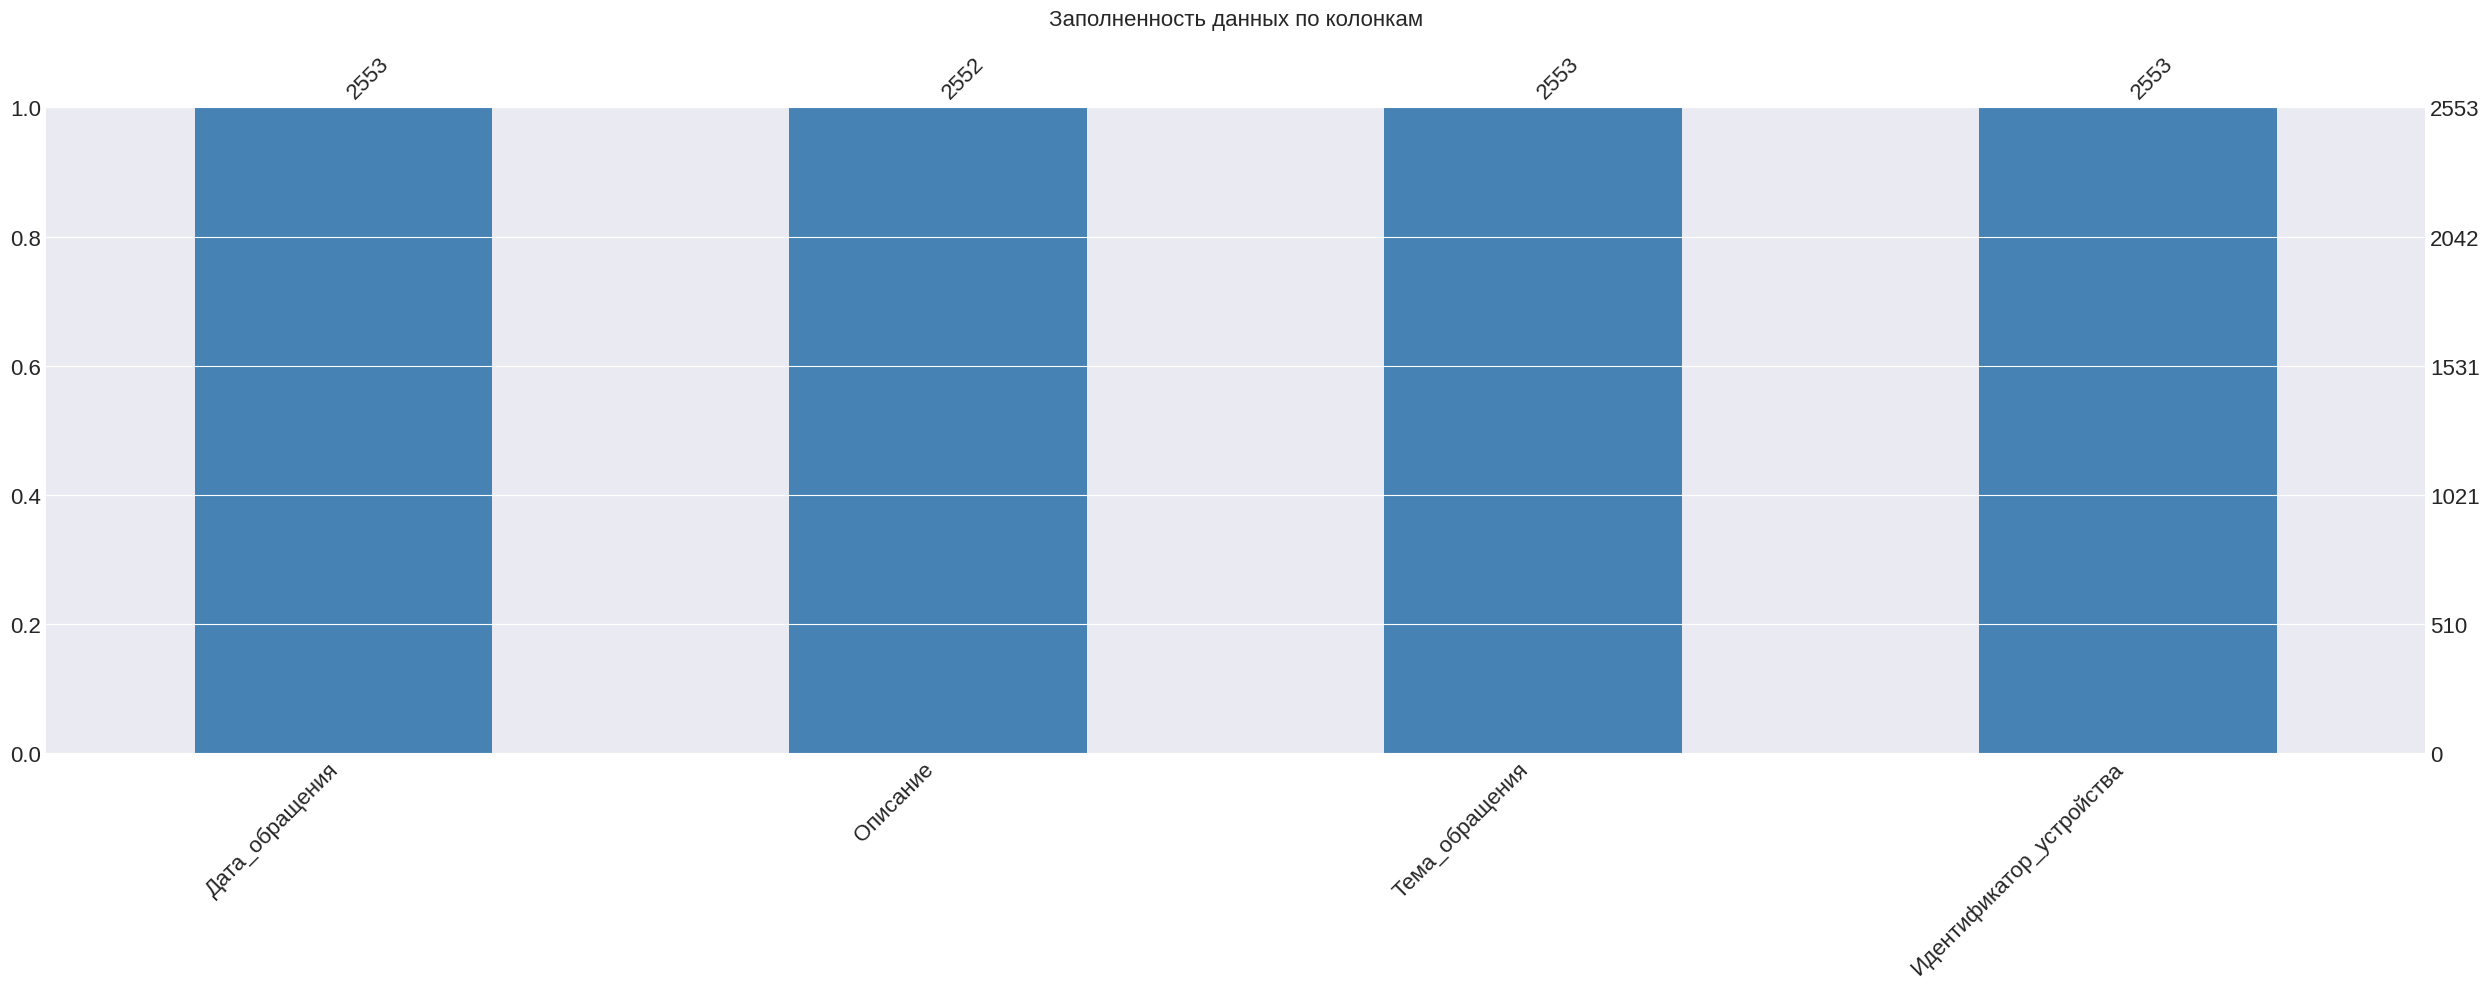

In [4]:

print("АНАЛИЗ ПРОПУЩЕННЫХ ДАННЫХ")


missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Колонка': missing_data.index,
    'Пропущено': missing_data.values,
    'Процент': missing_percent.values
})

print(missing_df)

plt.figure(figsize=(10, 6))
msno.bar(df, color='steelblue')
plt.title('Заполненность данных по колонкам', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

In [5]:

print("ОБРАБОТКА ДАТЫ")

def extract_date(date_str):
    try:
        if isinstance(date_str, str):

            date_part = date_str.split('[')[0] if '[' in date_str else date_str

            return pd.to_datetime(date_part, errors='coerce')
        return pd.to_datetime(date_str, errors='coerce')
    except:
        return pd.NaT

df['Дата_обращения_clean'] = df['Дата_обращения'].apply(extract_date)

df['Год'] = df['Дата_обращения_clean'].dt.year
df['Месяц'] = df['Дата_обращения_clean'].dt.month
df['День'] = df['Дата_обращения_clean'].dt.day
df['День_недели'] = df['Дата_обращения_clean'].dt.day_name()
df['Час'] = df['Дата_обращения_clean'].dt.hour
df['Месяц_год'] = df['Дата_обращения_clean'].dt.to_period('M')

print(f"Диапазон дат: {df['Дата_обращения_clean'].min()} - {df['Дата_обращения_clean'].max()}")
print(f"Количество дней с обращениями: {df['Дата_обращения_clean'].dt.date.nunique()}")

ОБРАБОТКА ДАТЫ
Диапазон дат: 2025-09-01 08:41:55+03:00 - 2025-10-31 18:40:19+03:00
Количество дней с обращениями: 61


АНАЛИЗ ТЕМ ОБРАЩЕНИЙ
Топ-10 тем обращений:
                                                Тема  Количество    Процент
0                                     Запрос портала        2385  93.419506
1                          Приложение. Умные решения         107   4.191148
2                          Общие вопросы оказания ГУ           9   0.352526
3                                       (no subject)           5   0.195848
4                                       ЕПД / Оплата           3   0.117509
5        Запрос контактных данных администратора ОСС           2   0.078339
6           Не открывается протокол ОСС в приложении           2   0.078339
7                                 Технические ошибки           2   0.078339
8                                                Дом           2   0.078339
9  Формирование документов для ОСС, домофон iCityPro           1   0.039170


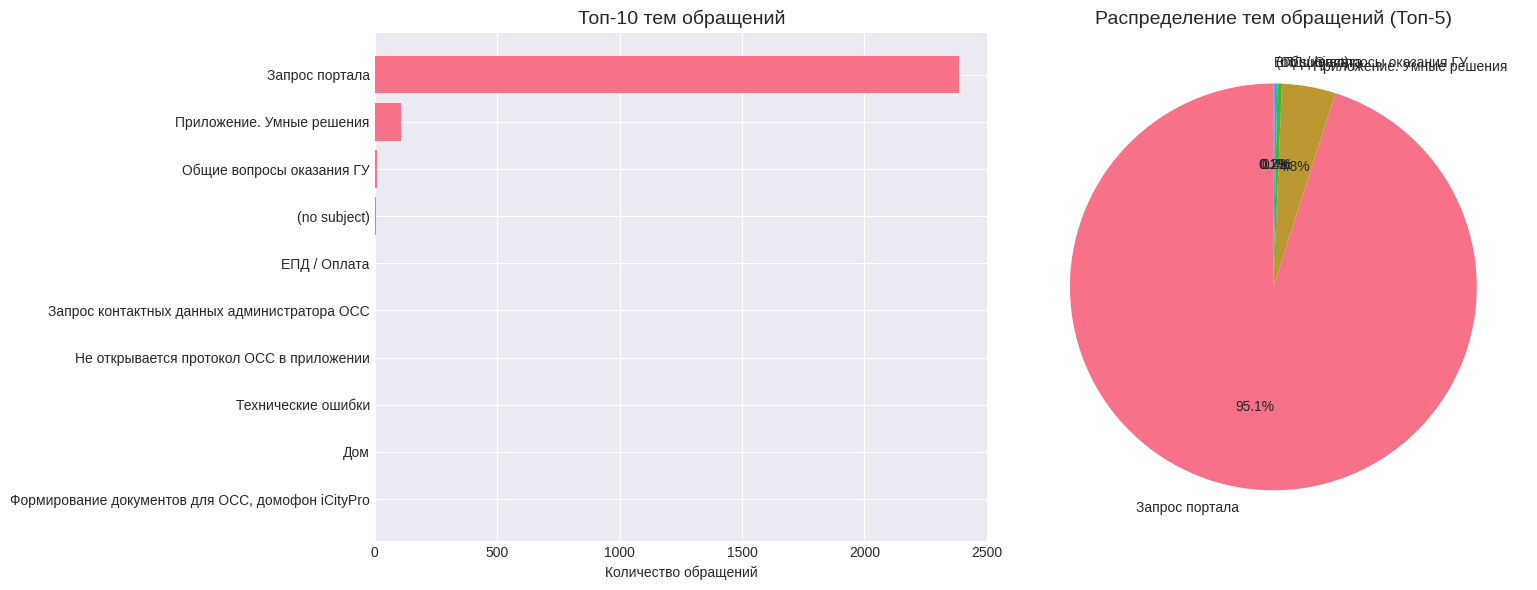

In [6]:

print("АНАЛИЗ ТЕМ ОБРАЩЕНИЙ")

theme_counts = df['Тема_обращения'].value_counts()
theme_percent = (theme_counts / len(df)) * 100

theme_stats = pd.DataFrame({
    'Тема': theme_counts.index,
    'Количество': theme_counts.values,
    'Процент': theme_percent.values
})

print("Топ-10 тем обращений:")
print(theme_stats.head(10))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].barh(theme_stats['Тема'].head(10), theme_stats['Количество'].head(10))
axes[0].set_xlabel('Количество обращений')
axes[0].set_title('Топ-10 тем обращений', fontsize=14)
axes[0].invert_yaxis()


axes[1].pie(theme_stats['Количество'].head(5), labels=theme_stats['Тема'].head(5),
           autopct='%1.1f%%', startangle=90)
axes[1].set_title('Распределение тем обращений (Топ-5)', fontsize=14)

plt.tight_layout()
plt.show()

ВРЕМЕННОЙ АНАЛИЗ ОБРАЩЕНИЙ


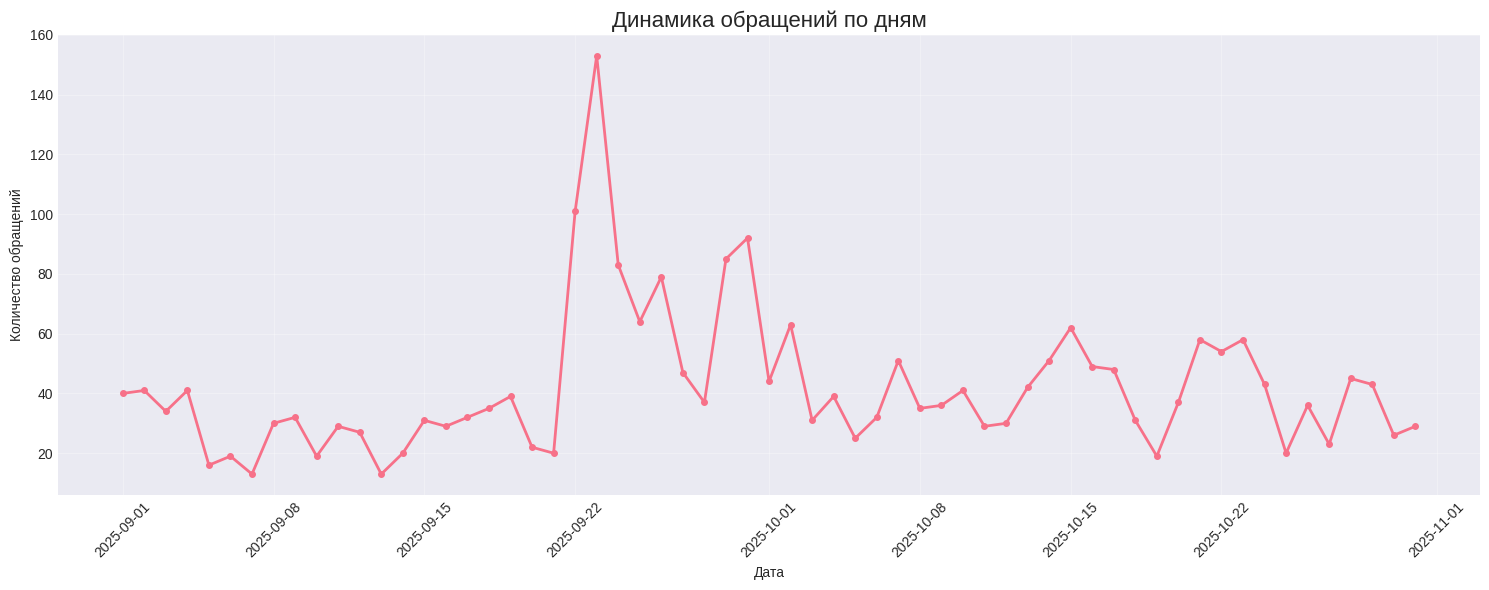

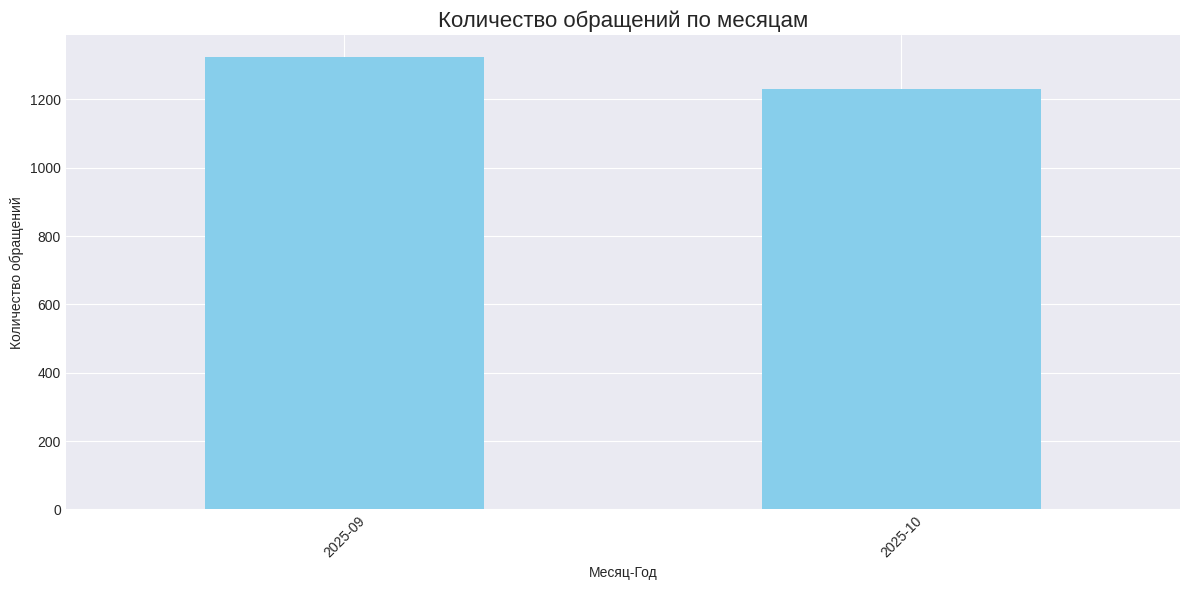

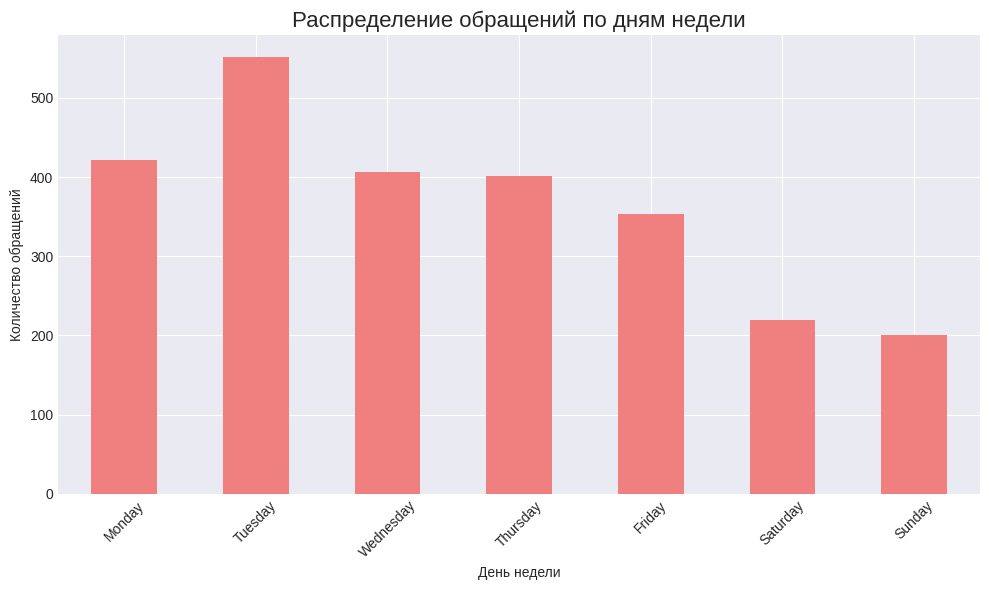

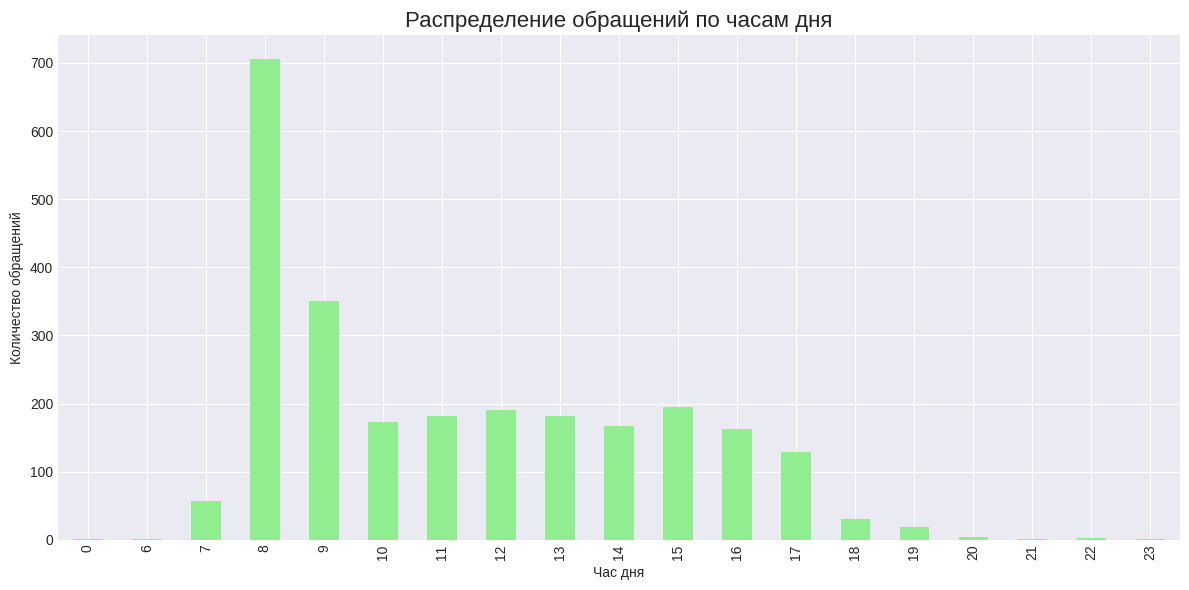

In [7]:



print("ВРЕМЕННОЙ АНАЛИЗ ОБРАЩЕНИЙ")

daily_counts = df.groupby(df['Дата_обращения_clean'].dt.date).size()

plt.figure(figsize=(15, 6))
plt.plot(daily_counts.index, daily_counts.values, marker='o', linewidth=2, markersize=4)
plt.xlabel('Дата')
plt.ylabel('Количество обращений')
plt.title('Динамика обращений по дням', fontsize=16)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

monthly_counts = df.groupby('Месяц_год').size()

plt.figure(figsize=(12, 6))
monthly_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Месяц-Год')
plt.ylabel('Количество обращений')
plt.title('Количество обращений по месяцам', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

weekday_counts = df['День_недели'].value_counts()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = weekday_counts.reindex(weekday_order)

plt.figure(figsize=(10, 6))
weekday_counts.plot(kind='bar', color='lightcoral')
plt.xlabel('День недели')
plt.ylabel('Количество обращений')
plt.title('Распределение обращений по дням недели', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

hourly_counts = df['Час'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
hourly_counts.plot(kind='bar', color='lightgreen')
plt.xlabel('Час дня')
plt.ylabel('Количество обращений')
plt.title('Распределение обращений по часам дня', fontsize=16)
plt.tight_layout()
plt.show()

АНАЛИЗ УСТРОЙСТВ
Типы данных в колонке после преобразования:
Идентификатор_устройства_num
<class 'int'>    2552
<class 'str'>       1
Name: count, dtype: int64

Статистика по идентификаторам устройств (только числовые):
count      2553
unique     2063
top       10466
freq         21
Name: Идентификатор_устройства_num, dtype: int64

Полная информация:
Всего обращений: 2553
Уникальных устройств: 2063
Среднее обращений на устройство: 1.24

Топ-10 устройств по обращениям:
  10466: 21 обращений
  30159: 8 обращений
  22352: 8 обращений
  19447: 7 обращений
  59365: 7 обращений
  2279: 7 обращений
  58716: 6 обращений
  8774: 5 обращений
  38445: 5 обращений
  41095: 5 обращений


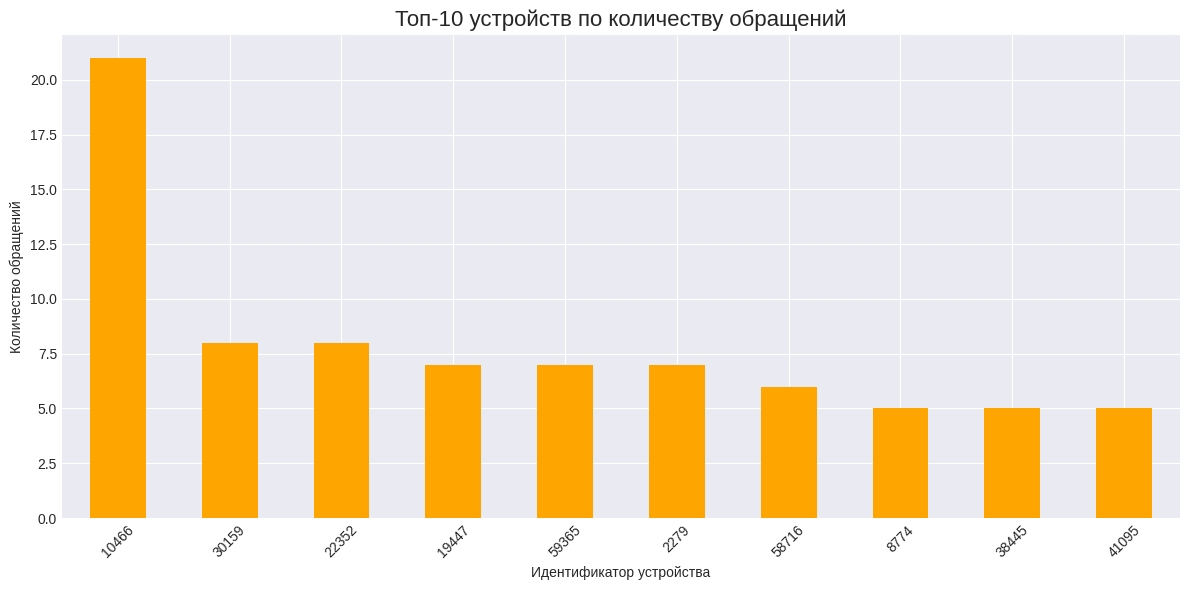

<Figure size 1200x800 with 0 Axes>

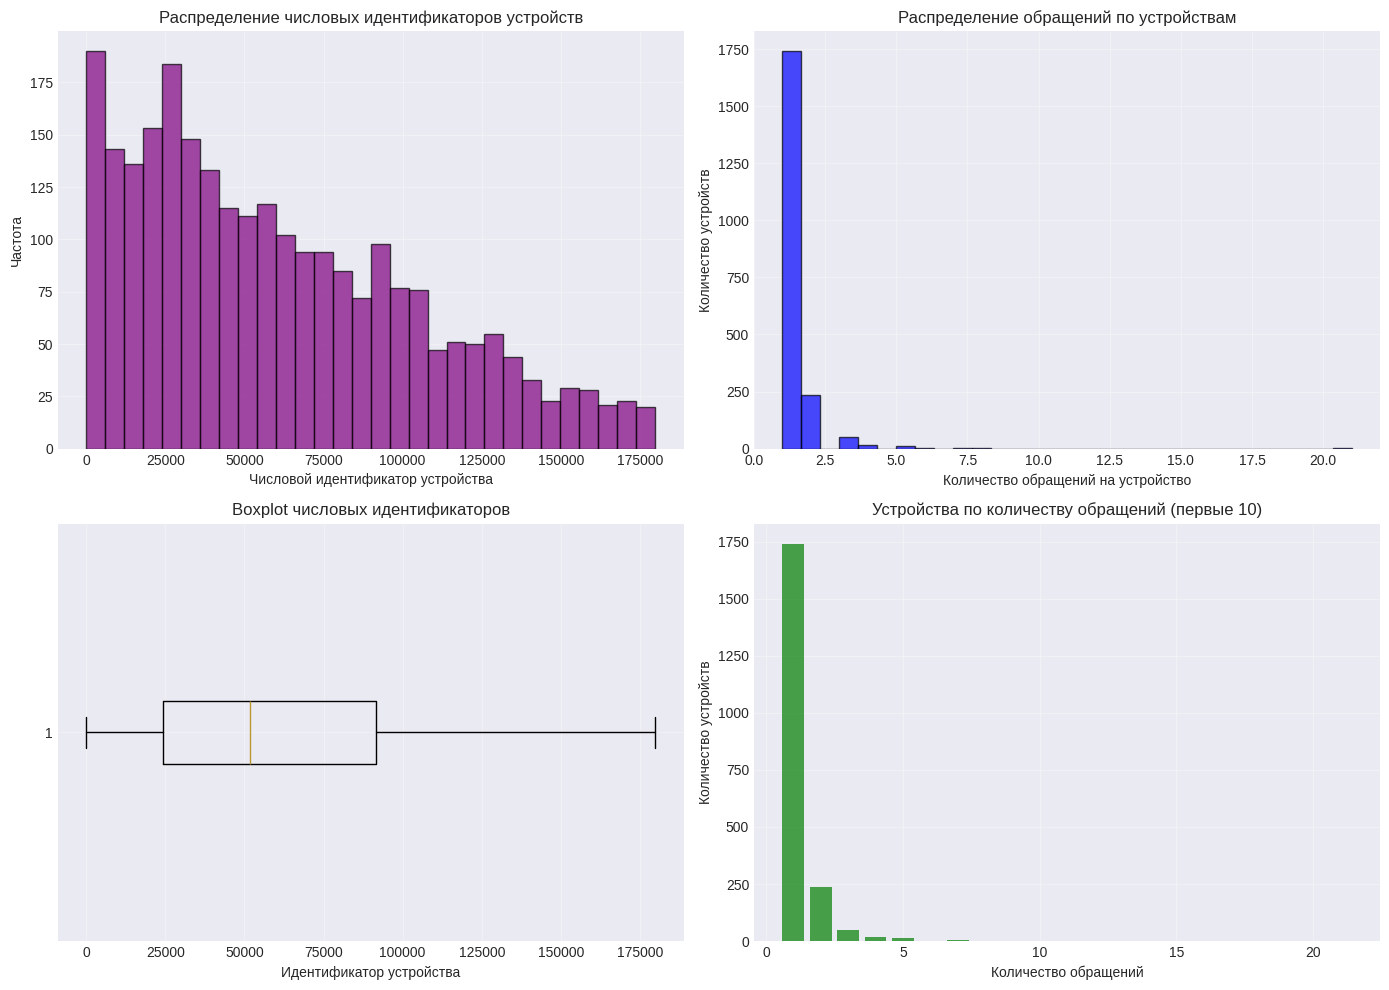

АНАЛИЗ ЧАСТОТЫ ОБРАЩЕНИЙ С УСТРОЙСТВ

Распределение устройств по частоте обращений:
 Количество обращений  Количество устройств
                    1                  1741
                    2                   237
                    3                    50
                    4                    16
                    5                    12
                    6                     1
                    7                     3
                    8                     2
                   21                     1

Устройств с одним обращением: 1741 (84.4%)

Устройства с наибольшим количеством обращений:
  Устройство 10466: 21 обращений

Среднее обращений на устройство: 1.24
Медиана обращений на устройство: 1.00
Стандартное отклонение: 0.79

Топ-20 самых активных устройств:
 1. Устройство 10466:  21 обращений (0.8% от всех)
 2. Устройство 30159:   8 обращений (0.3% от всех)
 3. Устройство 22352:   8 обращений (0.3% от всех)
 4. Устройство 19447:   7 обращений (0.3% от всех)
 5. Уст

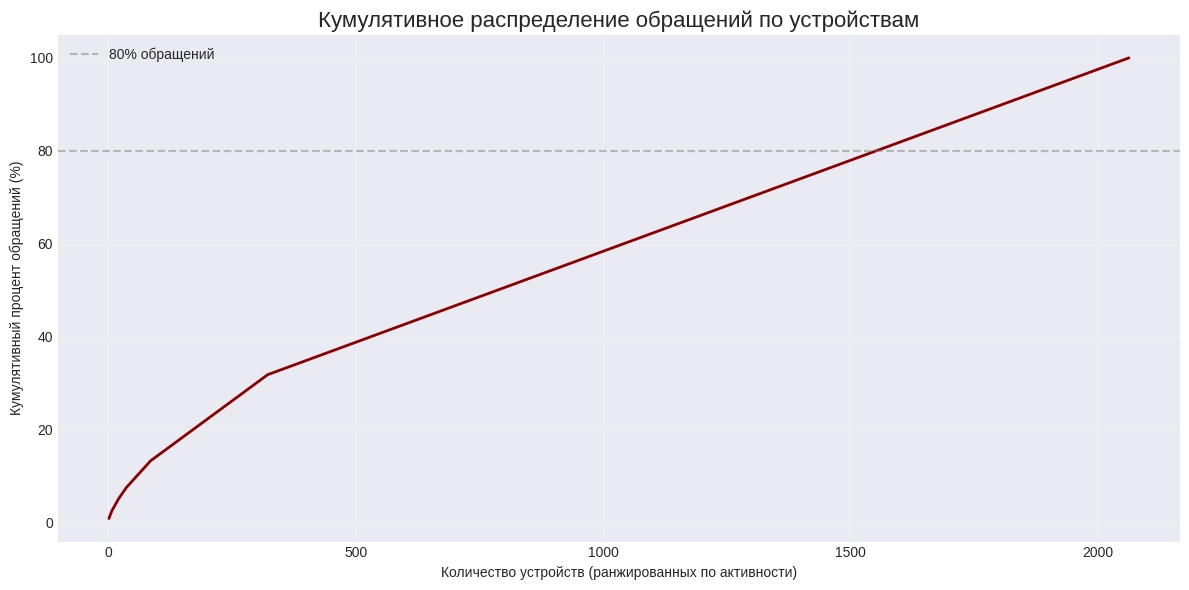


1553 устройств создают 80% всех обращений
Это 75.2% от всех устройств


In [12]:
print("АНАЛИЗ УСТРОЙСТВ")

def convert_to_numeric(x):
    try:

        return int(float(x))
    except:

        return x

df['Идентификатор_устройства_num'] = df['Идентификатор_устройства'].apply(convert_to_numeric)

print("Типы данных в колонке после преобразования:")
print(df['Идентификатор_устройства_num'].apply(type).value_counts().head())

device_stats = df['Идентификатор_устройства_num'].describe()
print("\nСтатистика по идентификаторам устройств (только числовые):")
print(device_stats)

print("\nПолная информация:")
print(f"Всего обращений: {len(df)}")
print(f"Уникальных устройств: {df['Идентификатор_устройства'].nunique()}")
print(f"Среднее обращений на устройство: {len(df) / df['Идентификатор_устройства'].nunique():.2f}")

top_devices = df['Идентификатор_устройства'].value_counts().head(10)

print(f"\nТоп-10 устройств по обращениям:")
for device, count in top_devices.items():
    print(f"  {device}: {count} обращений")

plt.figure(figsize=(12, 6))
top_devices.plot(kind='bar', color='orange')
plt.xlabel('Идентификатор устройства')
plt.ylabel('Количество обращений')
plt.title('Топ-10 устройств по количеству обращений', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Гистограмма для числовых идентификаторов
numeric_mask = df['Идентификатор_устройства_num'].apply(lambda x: isinstance(x, (int, float)))
if numeric_mask.any():
    numeric_ids = df.loc[numeric_mask, 'Идентификатор_устройства_num']
    axes[0, 0].hist(numeric_ids, bins=30, color='purple', alpha=0.7, edgecolor='black')
    axes[0, 0].set_xlabel('Числовой идентификатор устройства')
    axes[0, 0].set_ylabel('Частота')
    axes[0, 0].set_title('Распределение числовых идентификаторов устройств', fontsize=12)
    axes[0, 0].grid(True, alpha=0.3)

# Распределение количества обращений на устройство
device_counts = df['Идентификатор_устройства'].value_counts()
axes[0, 1].hist(device_counts.values, bins=30, color='blue', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Количество обращений на устройство')
axes[0, 1].set_ylabel('Количество устройств')
axes[0, 1].set_title('Распределение обращений по устройствам', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

# Boxplot для числовых идентификаторов
if numeric_mask.any():
    axes[1, 0].boxplot(numeric_ids, vert=False)
    axes[1, 0].set_xlabel('Идентификатор устройства')
    axes[1, 0].set_title('Boxplot числовых идентификаторов', fontsize=12)
    axes[1, 0].grid(True, alpha=0.3)

# Доля устройств с разным количеством обращений
unique_counts = device_counts.value_counts().sort_index()
axes[1, 1].bar(unique_counts.index[:10], unique_counts.values[:10], color='green', alpha=0.7)
axes[1, 1].set_xlabel('Количество обращений')
axes[1, 1].set_ylabel('Количество устройств')
axes[1, 1].set_title('Устройства по количеству обращений (первые 10)', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


print("АНАЛИЗ ЧАСТОТЫ ОБРАЩЕНИЙ С УСТРОЙСТВ")

frequency_dist = pd.DataFrame({
    'Количество обращений': device_counts.value_counts().index,
    'Количество устройств': device_counts.value_counts().values
}).sort_values('Количество обращений')

print("\nРаспределение устройств по частоте обращений:")
print(frequency_dist.head(10).to_string(index=False))

# Процент устройств с одним обращением
single_appeal = (device_counts == 1).sum()
single_appeal_percent = (single_appeal / len(device_counts)) * 100
print(f"\nУстройств с одним обращением: {single_appeal} ({single_appeal_percent:.1f}%)")

# Устройства с максимальным количеством обращений
print(f"\nУстройства с наибольшим количеством обращений:")
max_appeals = device_counts.max()
top_problem_devices = device_counts[device_counts == max_appeals]
for device, count in top_problem_devices.items():
    print(f"  Устройство {device}: {count} обращений")

# Среднее и медиана обращений на устройство
print(f"\nСреднее обращений на устройство: {device_counts.mean():.2f}")
print(f"Медиана обращений на устройство: {device_counts.median():.2f}")
print(f"Стандартное отклонение: {device_counts.std():.2f}")

# Анализ топ-20 самых активных устройств
print(f"\nТоп-20 самых активных устройств:")
for i, (device, count) in enumerate(device_counts.head(20).items(), 1):
    print(f"{i:2}. Устройство {device}: {count:3} обращений ({count/len(df)*100:.1f}% от всех)")

plt.figure(figsize=(12, 6))
cumulative_percent = np.cumsum(device_counts.values) / np.sum(device_counts.values) * 100
plt.plot(range(1, len(cumulative_percent) + 1), cumulative_percent, linewidth=2, color='darkred')
plt.xlabel('Количество устройств (ранжированных по активности)')
plt.ylabel('Кумулятивный процент обращений (%)')
plt.title('Кумулятивное распределение обращений по устройствам', fontsize=16)
plt.grid(True, alpha=0.3)
plt.axhline(y=80, color='gray', linestyle='--', alpha=0.5, label='80% обращений')
plt.legend()
plt.tight_layout()
plt.show()

# Определяем, сколько устройств создают 80% обращений
eighty_percent_index = np.where(cumulative_percent >= 80)[0][0]
print(f"\n{device_counts.index[:eighty_percent_index+1].nunique()} устройств создают 80% всех обращений")
print(f"Это {eighty_percent_index/len(device_counts)*100:.1f}% от всех устройств")

In [32]:

print("Доступные колонки:")
print(df.columns.tolist())

theme_column = None
possible_names = ['Тема_обращения', 'Тема_обращение', 'Тема', 'Тема обращения']
for name in possible_names:
    if name in df.columns:
        theme_column = name
        break

if theme_column is None:
    theme_columns = [col for col in df.columns if 'тема' in col.lower() or 'theme' in col.lower()]
    if theme_columns:
        theme_column = theme_columns[0]
    else:
        theme_column = df.columns[2] if len(df.columns) > 2 else df.columns[-1]

print(f"\nИспользуемая колонка для тем: '{theme_column}'")

print("\n1. Анализ тем по месяцам:")

try:
    theme_month = pd.crosstab(df['Месяц'], df[theme_column], normalize='index') * 100


    top_themes = df[theme_column].value_counts().head(8).index
    theme_month_filtered = theme_month[top_themes]


    plt.figure(figsize=(14, 8))
    sns.heatmap(theme_month_filtered, cmap='YlOrRd', annot=True, fmt='.1f',
                linewidths=.5, cbar_kws={'label': 'Процент (%)'})
    plt.xlabel('Тема обращения', fontsize=12)
    plt.ylabel('Месяц', fontsize=12)
    plt.title('Распределение тем обращений по месяцам (топ-8 тем, %)', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

    print(f"Всего уникальных тем: {df[theme_column].nunique()}")
    print(f"Показано топ-{len(top_themes)} самых частых тем")

except Exception as e:
    print(f"Ошибка при создании heatmap: {e}")

    plt.figure(figsize=(14, 8))
    monthly_counts = df.groupby(['Месяц', theme_column]).size().unstack().fillna(0)
    monthly_counts[top_themes].plot(kind='area', stacked=True, alpha=0.7)
    plt.xlabel('Месяц')
    plt.ylabel('Количество обращений')
    plt.title('Динамика тем обращений по месяцам', fontsize=16)
    plt.legend(title='Темы', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

print("\n2. Анализ тем по дням недели:")

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_order_ru = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']


if 'День_недели' in df.columns:
    sample_day = df['День_недели'].iloc[0] if len(df) > 0 else ''
    if sample_day in weekday_order:
        day_mapping = dict(zip(weekday_order, weekday_order_ru))
        df['День_недели_рус'] = df['День_недели'].map(day_mapping)
        weekday_column = 'День_недели_рус'
        used_order = weekday_order_ru
    else:
        weekday_column = 'День_недели'
        used_order = weekday_order_ru
else:
    df['День_недели'] = df['Дата_обращения_clean'].dt.day_name()
    weekday_column = 'День_недели'
    used_order = weekday_order

try:
    weekday_theme = pd.crosstab(df[weekday_column], df[theme_column])


    top_theme_count = min(6, len(weekday_theme.columns))  # Не более 6 тем
    top_columns = weekday_theme.sum().nlargest(top_theme_count).index
    weekday_theme_filtered = weekday_theme[top_columns]


    weekday_theme_filtered = weekday_theme_filtered.reindex(used_order)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))


    weekday_theme_filtered.plot(kind='bar', ax=axes[0], width=0.8)
    axes[0].set_xlabel('День недели', fontsize=12)
    axes[0].set_ylabel('Количество обращений', fontsize=12)
    axes[0].set_title('Распределение тем обращений по дням недели', fontsize=14)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].legend(title='Темы', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0].grid(True, alpha=0.3)

    weekday_theme_norm = weekday_theme_filtered.div(weekday_theme_filtered.sum(axis=1), axis=0) * 100
    weekday_theme_norm.plot(kind='bar', stacked=True, ax=axes[1], width=0.8)
    axes[1].set_xlabel('День недели', fontsize=12)
    axes[1].set_ylabel('Процент обращений (%)', fontsize=12)
    axes[1].set_title('Процентное распределение тем по дням недели', fontsize=14)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].legend(title='Темы', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


    print(f"\nСтатистика по дням недели:")
    total_by_day = weekday_theme_filtered.sum(axis=1)
    for day in used_order:
        if day in total_by_day.index:
            count = total_by_day[day]
            percent = count / total_by_day.sum() * 100
            print(f"  {day}: {count} обращений ({percent:.1f}%)")

except Exception as e:
    print(f"Ошибка при анализе дней недели: {e}")


print("\n3. Дополнительный анализ:")

# Анализ тем по часам дня
plt.figure(figsize=(14, 8))
hour_theme = pd.crosstab(df['Час'], df[theme_column])
top_5_themes = hour_theme.sum().nlargest(5).index
hour_theme[top_5_themes].plot(kind='area', stacked=True, alpha=0.7)
plt.xlabel('Час дня', fontsize=12)
plt.ylabel('Количество обращений', fontsize=12)
plt.title('Динамика тем обращений по часам дня (топ-5 тем)', fontsize=16)
plt.legend(title='Темы', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Анализ наиболее активных часов для каждой темы
print("\nПиковые часы для каждой темы:")
for theme in top_5_themes:
    if theme in hour_theme.columns:
        peak_hour = hour_theme[theme].idxmax()
        peak_count = hour_theme[theme].max()
        print(f"  {theme}: пик в {peak_hour}:00 ({peak_count} обращений)")

# Анализ взаимосвязи темы и дня недели (тепловая карта)
plt.figure(figsize=(14, 8))
weekday_hour = pd.crosstab(df[weekday_column], df['Час'], normalize='index') * 100
sns.heatmap(weekday_hour.reindex(used_order), cmap='coolwarm', annot=True, fmt='.1f',
            linewidths=.5, cbar_kws={'label': 'Процент обращений (%)'})
plt.xlabel('Час дня', fontsize=12)
plt.ylabel('День недели', fontsize=12)
plt.title('Распределение обращений по дням недели и часам (%)', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

print("\n4. Корреляция между темами по дням недели:")

try:

    theme_dummies = pd.get_dummies(df[theme_column])


    df['День_недели_число'] = df['Дата_обращения_clean'].dt.dayofweek


    theme_by_day = theme_dummies.groupby(df['День_недели_число']).mean()

    correlation_matrix = theme_by_day.corr()


    top_10_themes = theme_dummies.sum().nlargest(10).index
    corr_top = correlation_matrix.loc[top_10_themes, top_10_themes]

    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_top, dtype=bool))
    sns.heatmap(corr_top, mask=mask, cmap='RdBu_r', center=0,
                annot=True, fmt='.2f', square=True,
                linewidths=.5, cbar_kws={'label': 'Коэффициент корреляции'})
    plt.title('Корреляция между темами обращений (топ-10 тем)', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()


    print("\nНаиболее коррелированные темы:")
    corr_pairs = []
    for i in range(len(corr_top.columns)):
        for j in range(i+1, len(corr_top.columns)):
            if abs(corr_top.iloc[i, j]) > 0.3:  # Порог корреляции
                corr_pairs.append((corr_top.columns[i], corr_top.columns[j], corr_top.iloc[i, j]))


    corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

    for theme1, theme2, corr_value in corr_pairs[:5]:
        print(f"  {theme1} ↔ {theme2}: {corr_value:.3f}")

except Exception as e:
    print(f"Ошибка при корреляционном анализе: {e}")



Доступные колонки:
['Дата_обращения', 'Описание', 'Тема_обращения', 'Идентификатор_устройства', 'Дата_обращения_clean', 'Год', 'Месяц', 'День', 'День_недели', 'Час', 'Месяц_год', 'Идентификатор_устройства_num', 'День_недели_рус', 'День_недели_число', 'Категория_проблемы']

Используемая колонка для тем: 'Тема_обращения'

1. Анализ тем по месяцам:
Всего уникальных тем: 45
Показано топ-8 самых частых тем

2. Анализ тем по дням недели:

Статистика по дням недели:
  Понедельник: 415 обращений (16.5%)
  Вторник: 547 обращений (21.8%)
  Среда: 395 обращений (15.7%)
  Четверг: 392 обращений (15.6%)
  Пятница: 348 обращений (13.9%)
  Суббота: 217 обращений (8.6%)
  Воскресенье: 197 обращений (7.8%)

3. Дополнительный анализ:

Пиковые часы для каждой темы:
  Запрос портала: пик в 8:00 (685 обращений)
  Приложение. Умные решения: пик в 12:00 (20 обращений)
  Общие вопросы оказания ГУ: пик в 15:00 (4 обращений)
  (no subject): пик в 10:00 (1 обращений)
  ЕПД / Оплата: пик в 8:00 (1 обращений)

4. 